In [1]:
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import sys
import matplotlib.pyplot as plt 
np.set_printoptions(threshold=sys.maxsize)

In [2]:
csv1 = pd.read_csv('sequence_execution_time.csv')

In [3]:
#csv1.tail()

In [4]:
data = csv1

In [5]:
data = data.drop(csv1.index[200000:])

In [6]:
#data.tail()

In [7]:
data.describe()

,execution_time
count,200000.000000
mean,2014.272302
std,4031.745130
min,184.125000
25%,560.667000
50%,676.709000
75%,1414.031250
max,124555.542000


In [8]:
reads = data.drop(['sequence_identifier','quality'], axis =1)
#reads

In [9]:
#Normalize data
reads['execution_time'] = np.log10(reads.execution_time)
#reads

In [10]:
def Kmers_funct(seq, size=9): 
   return [seq[x:x+size].upper() for x in range(len(seq) - size + 1)]

reads['words'] = reads.apply(lambda x: Kmers_funct(x['read_sequence']), axis=1)
reads = reads.drop('read_sequence', axis=1)

In [11]:
reads

,execution_time,words
0,3.360806,"[CTGGTCCTA, TGGTCCTAA, GGTCCTAAC, GTCCTAACA, T..."
1,2.828660,"[TGGCTATGG, GGCTATGGG, GCTATGGGC, CTATGGGCT, T..."
2,2.879216,"[ACTTTCTAT, CTTTCTATC, TTTCTATCT, TTCTATCTC, T..."
3,2.598836,"[ATCAAAAAC, TCAAAAACA, CAAAAACAT, AAAAACATT, A..."
4,2.829304,"[CAGGTTCCA, AGGTTCCAA, GGTTCCAAT, GTTCCAATA, T..."
...,...,...
199995,2.335207,"[ACAGTAAGA, CAGTAAGAG, AGTAAGAGA, GTAAGAGAA, T..."
199996,2.389093,"[ATAAATGAA, TAAATGAAG, AAATGAAGA, AATGAAGAT, A..."
199997,2.993105,"[GACTGGATT, ACTGGATTA, CTGGATTAA, TGGATTAAG, G..."
199998,2.585132,"[GAAAGTATT, AAAGTATTG, AAGTATTGA, AGTATTGAC, G..."


In [12]:
human_texts = list(reads['words'])
for item in range(len(human_texts)):
   human_texts[item] = ' '.join(human_texts[item])
#separate labels
y_human = reads.iloc[:, 0].values # y_human for human_dna

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
cv = CountVectorizer(ngram_range = (4,4)) # initially (4,4)
X = cv.fit_transform(human_texts)

In [14]:
Y= y_human

X= X

In [15]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math

In [16]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (160000, 8121697)
X_test (40000, 8121697)
y_train (160000,)
y_test (40000,)


In [17]:
from catboost import  EShapCalcType, EFeaturesSelectionAlgorithm

In [18]:
cat_model = CatBoostRegressor( random_seed = 42) #, early_stopping_rounds = 100, , save_snapshot = True, snapshot_interval = 60, iterations= 10000, early_stopping_rounds = 100, 

In [19]:
# Fit model and validate
cat_model.fit( X_train, y_train,
               eval_set=(X_test, y_test),
               plot=True,
              verbose = False
              )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [20]:
# summary = cat_model.select_features(
#                     X = X_train,
#                     y = y_train,
#                     eval_set=(X_test, y_test),
#                     features_for_select='0-128376',
#                     num_features_to_select = 12830,
#                     steps = 2,
#                     algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
#                     shap_calc_type=EShapCalcType.Regular,
#                     train_final_model=True,
#                     logging_level='Silent',
#                     plot=True
                    
# )

In [21]:
# feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))

# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data = feature_importance,palette="cool");
# plt.title('feature importance');

In [27]:
y_predict_train = cat_model.predict(X_train)
y_predict= cat_model.predict(X_test)
#RMSE
Rmse_train = math.sqrt(mean_squared_error(y_train,y_predict_train ))
Rmse_test = math.sqrt(mean_squared_error(y_test,y_predict))

#R
r2_train = cat_model.score(X_train,y_train)
r2_test = r2_score(y_test,y_predict)

# Adjusted R2 
n= X_train.shape[0] 
p= X_train.shape[1] 
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)


print("Evaluation on test data")
print("RMSE train: {:.2f}".format(Rmse_train))
print("RMSE test: {:.2f}".format(Rmse_test))
print("R2 train: {:.2f}".format(r2_train))
print("R2 test: {:.2f}".format(r2_test))
print("Adjusted R2 test: {:.2f}".format(adj_r2_test)) 

Evaluation on test data
RMSE train: 0.29
RMSE test: 0.31
R2 train: 0.57
R2 test: 0.52
Adjusted R2 test: 1.01


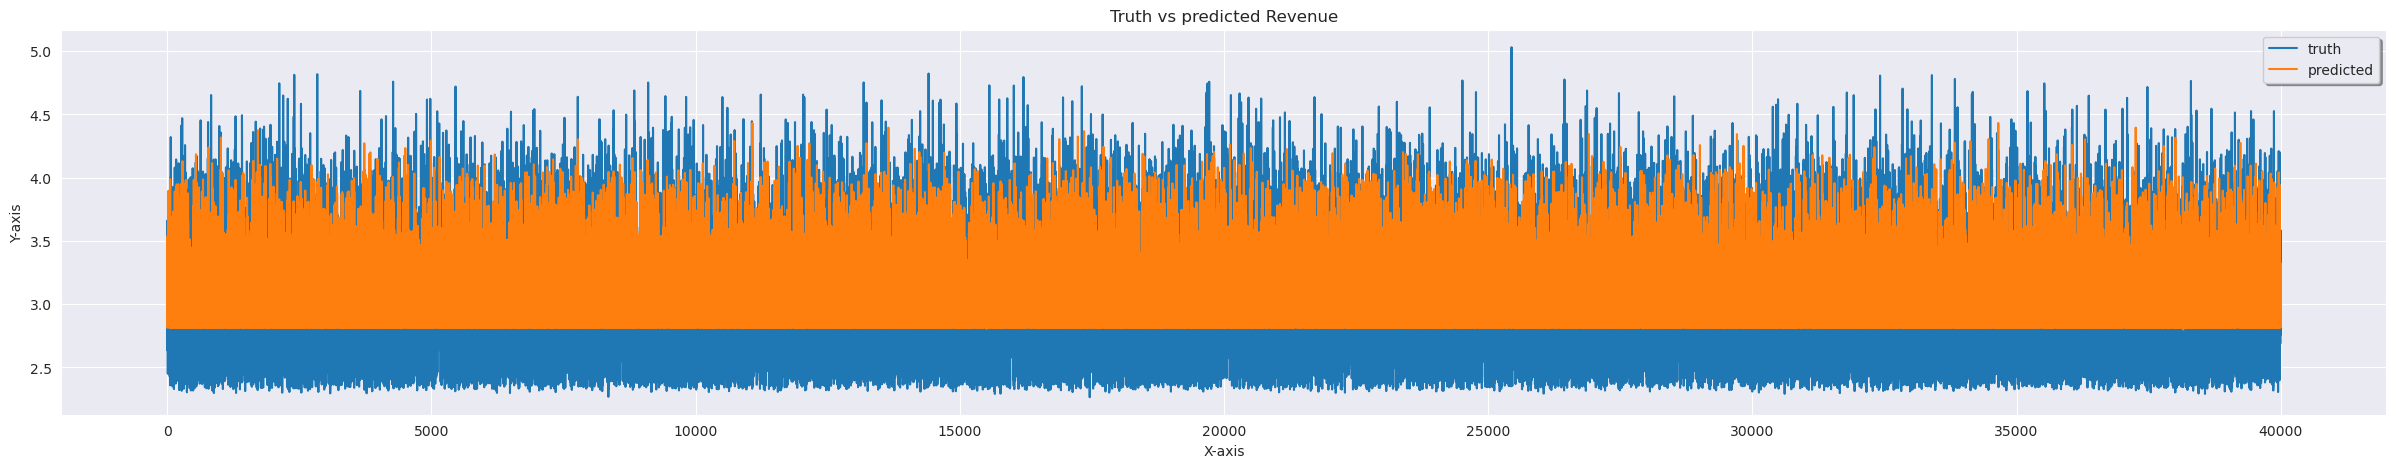

In [28]:
x_ax = range(len(y_test))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.plot(x_ax, y_test, label="truth")
plt.plot(x_ax, y_predict, label="predicted")
plt.title("Truth vs predicted Revenue")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [29]:
y_pred_non_log = 10**(y_predict) 
y_test_non_log = 10**(y_test)

In [30]:
from sklearn.metrics import mean_squared_log_error
rmsle = mean_squared_log_error(y_test_non_log,y_pred_non_log)**0.5
rmsle                                  

0.7210336472461136

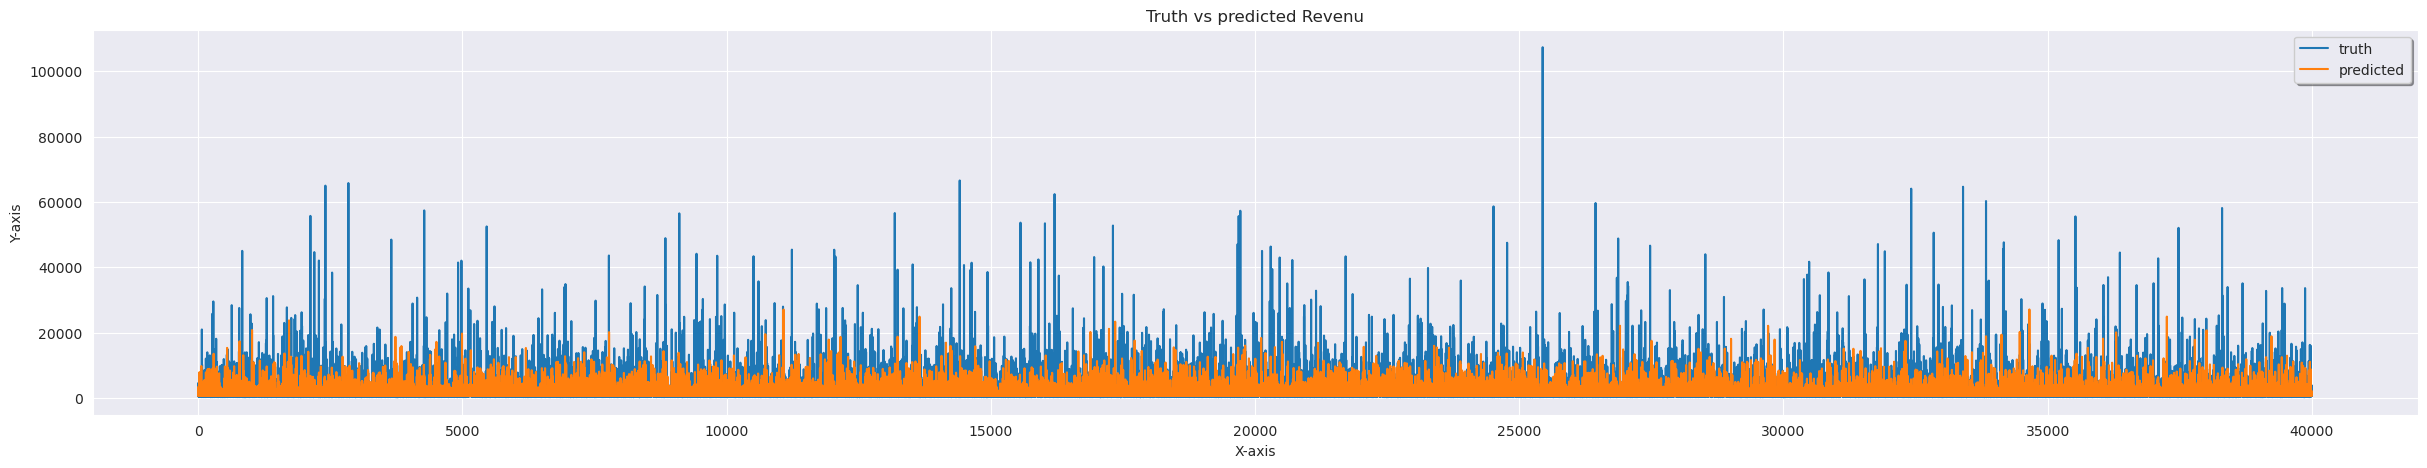

In [31]:
x_ax = range(len(y_test_non_log))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.plot(x_ax, y_test_non_log, label="truth")
plt.plot(x_ax, y_pred_non_log, label="predicted")
plt.title("Truth vs predicted Revenu")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()